In [1]:
## 
import tensorflow as tf
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from numpy import argmax
import os
from sklearn.metrics import average_precision_score
import datetime
from sklearn.preprocessing import MinMaxScaler
import math
import random
import csv
import os
import glob
import random
from keras import backend as K
import time
from functools import partial
import warnings
from keras.layers import Bidirectional, TimeDistributed, LSTM, Input, Dense, GRU, Dropout, InputLayer
from keras.models import Model, clone_model
from keras.callbacks import ModelCheckpoint
from datetime import date
import shutil

warnings.filterwarnings("ignore")

## 전처리한 데이터 불러오기 Train, Test

In [2]:
# Train data 불러오기
start = time.time()
Training_Data = pd.read_csv('Change_train.csv')
Test_Data = pd.read_csv('Change_test.csv')
submission = pd.read_csv('submission.csv')
Pre_Best=pd.read_csv("G:/공유 드라이브/HiWi/태양광 전력 예측 공모전/1. 제출용파일 폴더/pre_best.csv")
Pre_Best=np.array(Pre_Best)
Best=pd.read_csv("G:/공유 드라이브/HiWi/태양광 전력 예측 공모전/1. 제출용파일 폴더/best_file.csv")
Best=np.array(Best)
Training_Data.head()

,Day,Hour,DHI,DNI,WS,RH,T,TARGET
0,0.0,4.5,0.0,0.0,1.3,74.61,-11.0,0.0
1,0.0,5.0,0.0,0.0,1.3,73.74,-11.0,0.0
2,0.0,5.5,0.0,0.0,1.3,73.73,-11.0,0.0
3,0.0,6.0,0.0,0.0,1.4,72.22,-12.0,0.0
4,0.0,6.5,0.0,0.0,1.4,72.22,-12.0,0.0


## Parameter 

In [3]:
# divide_train=5 # 몇 구간으로 나눌 것인가?
one_day=30 # 하루 (단위: 분)
origin_day=96
# divide_zone=math.floor((1095)/divide_train) # 나눌 구간 조정 (단위: 일)
# Validation_day=one_day*2 # 원하는 Validation 만들기 ex) 30 * 7 = 210 -> 뒤에서 일주일 가져오기
seq_length=one_day * 5 # 1 ~ 210까지 가능
#[1,2,3,4,5,6,10,12,15,20,30,60] => 60(2일 데이터)의 약수
future_length=one_day * 2 # ex) 1이면 1개씩=60, 2면 2개씩=30.....30개 2개=2
# act= 'relu' #activation

drop=0.10
tau=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
num_test=81
batch=2000


seed=[4]
ensemble_model_num=len(seed)
layers=4
Dense_num=120
# LSTM_layers=4
# Bi_LSTM_layers=4



## 파일 이름 지정하기

In [4]:

# total_name = ()
# total_file_name = []
today = date.today()

# ########### 1. BI_LSTM ---- 2. CNN ---- 3. RMM 순으로 모델링이 된다. ###########
    
# for i in range(len(tau)):
#     exec('Model_name%d = [act[%d], int(total_iter[%d]), Model_Select[%d]]'%(i+1, i, i, i))
# #     exec('Model_name%d = [tau[%d], act[%d], int(total_iter[%d]), train_num[%d]+1]'%(i+1, i, i, i, i))


# file_name = f'{today}-{int(seq_length/one_day)}day{Model_name_total[0:]}'
file_name = f'{today}-{int(seq_length/one_day)}day_{seed[0]}'
print(file_name)
## file_name은 날짜 - 몇일(day) - q(0.1~0.9순으로) [activation, total_epochs, model_num]순으로 구성
file_name = str(file_name)

2021-01-26-5day_4


## 학습모델 지정

In [5]:
#Quantile 마다 학습 모델을 설정한다.(총 9개에 대한 모델과 iteration, learning rate를 지정한다.)
Model_Select=[1,1,1,1,1,1,1,1,1]
#iteration = [5000,5000,5000,5000,5000,5000,5000,5000,5000]
iteration = [10000,10000,10000,10000,10000,10000,10000,10000,10000]
learning_rate = [0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001]

act=['selu','selu','selu','selu','selu','selu','selu','selu','selu']

Num_unit1=[5,5,5,5,5,5,5,5,5]
Num_unit2=[5,5,5,5,5,5,5,5,5]

total_iter=[10000,10000,10000,10000,10000,10000,10000,10000,10000]


In [6]:
# for i in range(5):
#     globals()[f'filePath{i+1}'] = f'C:/Users/USER/Desktop/23일 Ensemble_Models pred_v1/test{i+1}'

# def search(dirname):
#     all_dir = []
#     filenames = os.listdir(dirname)
#     for filename in filenames:
#         full_filename = os.path.join(dirname, filename)
#         all_dir.append(full_filename)
#     return all_dir

# # print(filePath5)

# for j in range(5):
#     globals()[f'all_dir{j+1}'] = search(globals()[f'filePath{j+1}'])
#     for i in range(len(globals()[f'all_dir{j+1}'])):
#         shutil.rmtree(globals()[f'all_dir{j+1}'][i])

In [7]:
# Data 열 제거
Training_data=Training_Data.drop(['Day','WS','Hour','DHI','DNI','RH','T'],axis=1)
P_Training_data = np.array(Training_data)
Test_data=Test_Data.drop(['Day','WS','Hour','DHI','DNI','RH','T'],axis=1)
test_data = np.array(Test_data)

In [8]:
Num_col=len(P_Training_data[1])

In [9]:
## Normalizing Data (2개 중 하나 선택)
def MinMaxScaler(data): #데이터 마다 사이즈가 다르기 때문에 0~1사이로 스케일링
    numerator = data - min(np.min(data, 0)) #분자 사이즈
    denominator = max(np.max(data, 0)) - min(np.min(data, 0)) #분모 사이즈
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7),min(np.min(data, 0)),denominator+1e-7

# def StandardScaler(data): #평균을 제거하고 데이터를 단위 분산으로 조정.(기본스케일, 평균과 표준편차 사용)
#     return (data-np.mean(data, 0))/np.std(data,0),np.std(data,0),np.mean(data, 0)
def Re_MinMaxScaler(data,min_data,denominator):
    return data*denominator+min_data

def pinball(q,y_true, y_pred):
    error=y_true-y_pred
    tao = q
    pin = K.mean(K.maximum(q*error, (q-1)*error), axis=-1)
    return pin

def build_dataset(Training_data, seq_length, future_length,one_day):
    #Train=Training_data.shape[0]-future_length-1
    dataX = []  #x,y에 대해서 저장하기위해 리스트형으로 만듬.
    dataY = []
    moving_average=one_day
    for i in range(0, int((len(Training_data)-seq_length-future_length)/moving_average)+1): 
        _x = Training_data[i*moving_average:i*moving_average+seq_length,:]
        _y = Training_data[i*moving_average+seq_length:i*moving_average+seq_length+future_length,-1] 
        dataX.append(_x) #위에서 나온 _x를 dataX에 붙여서 저장
        dataY.append(_y) #위에서 나온 _y를 dataY에 붙여서 저장
    #print(f"TrainSet ({i})_FutureLength({future_length}): dataX{np.array(dataX).shape}, dataY{np.array(dataY).shape}")
    return np.array(dataX), np.array(dataY)

def build_testset(Test_data, seq_length, future_length):
    #Train=Training_data.shape[0]-future_length-1
    dataX = []  #x,y에 대해서 저장하기위해 리스트형으로 만듬.
    _x = Test_data[-seq_length:,:]
    dataX.append(_x) #위에서 나온 _x를 dataX에 붙여서 저장
    #print(f'TestSet({i}) : dataX{np.array(dataX).shape}')
    return np.array(dataX)

def Make_zero(Original_dataX,Predict_data,seq_length,future_length,one_day,tau):
    for i in range(Predict_data.shape[0]):
        for j in range(future_length):
            if(Predict_data[i,j]<=0):
                Predict_data[i,j]=0
    for i in range(Original_dataX.shape[0]):
        for j in range(one_day):
            Data_zero=[]
            for k in range(int(seq_length/one_day)):
                Data_zero.append(Original_dataX[i,j+one_day*k,-1])
            if(max(Data_zero)==0):
                Predict_data[i,j]=0
                Predict_data[i,j+one_day]=0
    return Predict_data

def one_day_to_original_day(Data):
    Predict_data_with_zero=np.zeros((Data.shape[0],96))            
    for i in range(Data.shape[0]):
        Predict_data_with_zero[i,9:9+30]=Data[i,:30]
        Predict_data_with_zero[i,9+48:9+30+48]=Data[i,30:]
    return Predict_data_with_zero

def Make_Data(Data,Pred,seq_length,future_length,Min,den,one_day,tau):
    Change_zero=Make_zero(Data,Pred,seq_length,future_length,one_day,tau)
    Pred_Origin=one_day_to_original_day(Change_zero)
    Pred_Origin=Re_MinMaxScaler(Pred_Origin,Min,den)
    return Pred_Origin

In [10]:
Total_Data_set=np.vstack((P_Training_data,test_data))

In [11]:
Scale_Data_set,Min,den = MinMaxScaler(Total_Data_set)

In [12]:
print(Min,den)

0.0 99.9139391


In [13]:
# Scale 된 Data들을 다시 분리
Train=Scale_Data_set[:P_Training_data.shape[0],:] # (32610, 6) (각 validation의 2일(*30)씩 뺀 값)
Test=Scale_Data_set[P_Training_data.shape[0]:,:] # (17010, 6) (81개*6일*30)
Test = np.reshape(Test,(1,Test.shape[0],Test.shape[1]))
print(Test.shape)

(1, 17010, 1)


## Build data set

In [14]:
trainX,trainY=build_dataset(Train,seq_length, future_length,one_day)
print(trainX.shape)
print(trainY.shape)

(1089, 150, 1)
(1089, 60)


In [15]:
for i in range(num_test):
    exec("testX%d=np.zeros((one_day*7,Num_col))"%(i+1))
    exec("testX%d[:,:]=Test[0,i*one_day*7:(i+1)*one_day*7,:]"%(i+1))

In [16]:
TEST=np.zeros((num_test,seq_length,Num_col))
for i in range(num_test):
    exec("TEST[i,:,:]=build_testset(testX%d, seq_length, future_length)"%(i+1))

## 학 습 Model

In [17]:
print(trainX[1].shape)
print(trainX.shape)
print(trainY.shape)

for j in range(1,1+ensemble_model_num): 
    for q in range(len(tau)):
        tf.random.set_seed(seed[j-1])
        #-----------Bidirectional LSTM Model------------
        globals()[f"model{j}_{q+1}"]=tf.keras.Sequential()
        globals()[f"model{j}_{q+1}"].add(Input(shape=(trainX.shape[1], trainX.shape[2])))
        globals()[f"model{j}_{q+1}"].add(LSTM(Num_unit1[q], return_sequences = True))
        globals()[f"model{j}_{q+1}"].add(Bidirectional(LSTM(Num_unit2[q])))
        for k in range(1,layers):
            globals()[f"model{j}_{q+1}"].add(Dense(units=Dense_num, activation=act[q]))
            globals()[f"model{j}_{q+1}"].add(Dropout(drop))
        globals()[f"model{j}_{q+1}"].add(Dense(units=future_length))
        exec("model%d_%d.compile(loss=lambda y,pred: pinball(tau[q],y,pred) ,optimizer=tf.optimizers.Adam(lr=learning_rate[q]))"%(j,q+1))
        exec("model%d_%d.summary()"%(j,q+1))

(150, 1)
(1089, 150, 1)
(1089, 60)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150, 5)            140       
_________________________________________________________________
bidirectional (Bidirectional (None, 10)                440       
_________________________________________________________________
dense (Dense)                (None, 120)               1320      
_________________________________________________________________
dropout (Dropout)            (None, 120)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               14520     
_________________________________________________________________
dropout_1 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_2 (Dense)      

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 150, 5)            140       
_________________________________________________________________
bidirectional_6 (Bidirection (None, 10)                440       
_________________________________________________________________
dense_24 (Dense)             (None, 120)               1320      
_________________________________________________________________
dropout_18 (Dropout)         (None, 120)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 120)               14520     
_________________________________________________________________
dropout_19 (Dropout)         (None, 120)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 120)              

------------------------------------------------------------------------------------------------------------------------
q = 0.1
------------------------------------------------------------------------------------------------------------------------
q = 0.2
------------------------------------------------------------------------------------------------------------------------
q = 0.3
------------------------------------------------------------------------------------------------------------------------
q = 0.4
------------------------------------------------------------------------------------------------------------------------
q = 0.5
------------------------------------------------------------------------------------------------------------------------
q = 0.6
------------------------------------------------------------------------------------------------------------------------
q = 0.7
-------------------------------------------------------------------------------------------------

<Figure size 432x288 with 0 Axes>

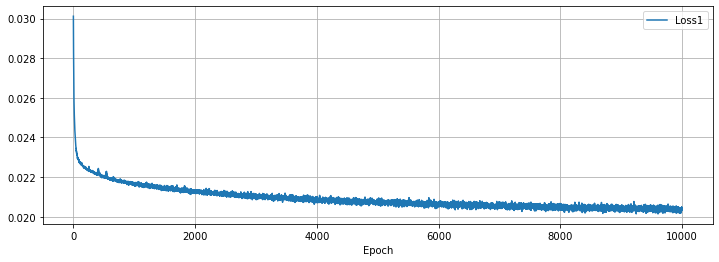

<Figure size 432x288 with 0 Axes>

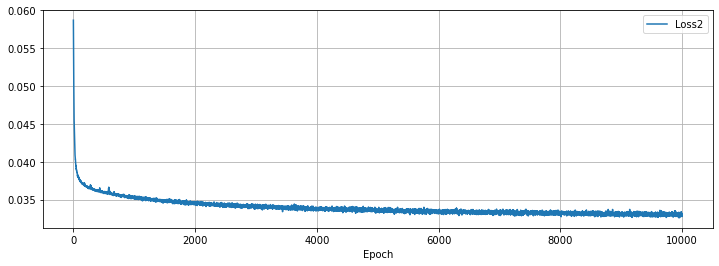

<Figure size 432x288 with 0 Axes>

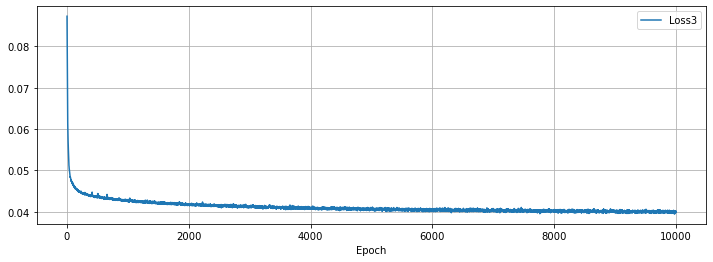

<Figure size 432x288 with 0 Axes>

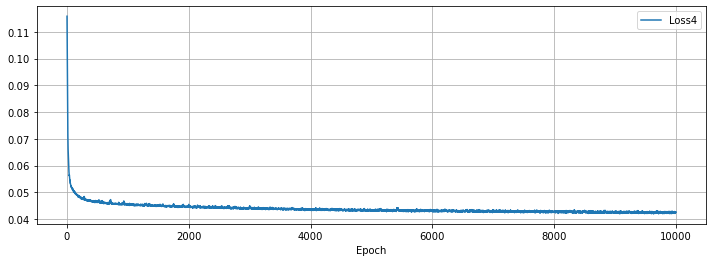

<Figure size 432x288 with 0 Axes>

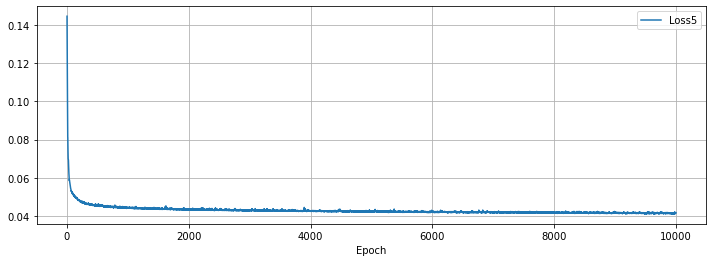

<Figure size 432x288 with 0 Axes>

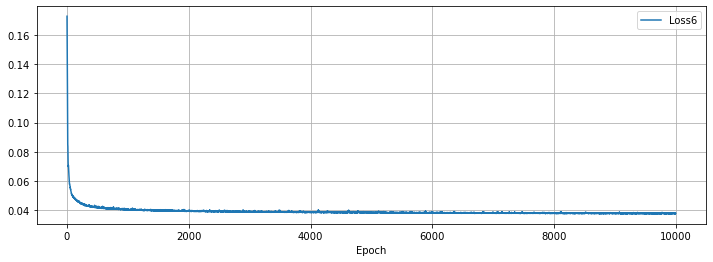

<Figure size 432x288 with 0 Axes>

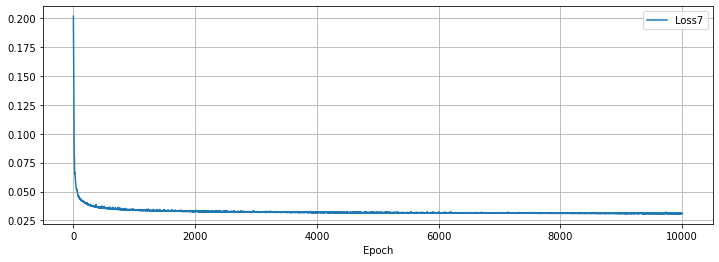

<Figure size 432x288 with 0 Axes>

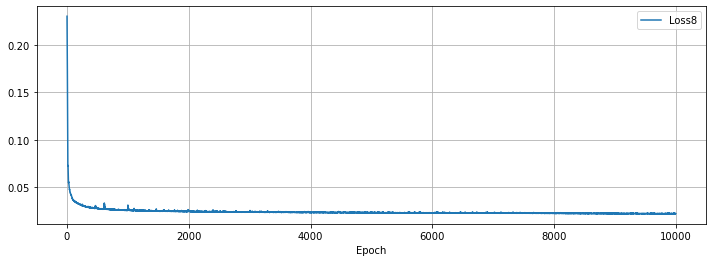

<Figure size 432x288 with 0 Axes>

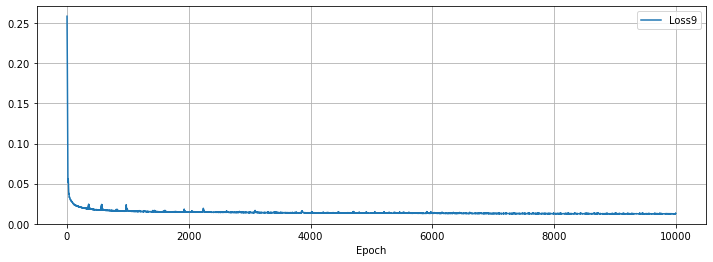

In [18]:
for q in range(len(tau)):
    for j in range(1,ensemble_model_num+1):
        tf.random.set_seed(seed[j-1])
    # ------------ pinball loss------------------ 
        print('-'*120)
        print("q = %.1f" %tau[q])
        
        exec("HISTORY%d_%d=model%d_%d.fit(trainX, trainY, epochs=iteration[q], batch_size=batch,verbose=0)"%(j,q+1,j,q+1))
        
        plt.figure()
        plt.figure(figsize=(12,4))
        exec("plt.plot(HISTORY%d_%d.history['loss'], label=f'Loss{q+1}')"%(j,q+1))
        plt.xlabel('Epoch')
        plt.legend()
        plt.grid()
    

## Train, Test 예측

In [19]:

for q in range(len(tau)):
    for j in range(1,ensemble_model_num+1):
        tf.random.set_seed(seed[j-1])
        exec("Train_Predict%d_%d=np.zeros((trainX.shape[0],future_length))"%(j,q+1))
        exec("Train_Predict%d_%d=model%d_%d.predict(trainX)"%(j,q+1,j,q+1))
        exec("Test_Predict%d_%d=np.zeros((num_test,future_length))"%(j,q+1))
        exec("Test_Predict%d_%d=model%d_%d.predict(TEST)"%(j,q+1,j,q+1))
    

In [20]:
for q in range(len(tau)):
    globals()[f"Train_Predict_Ensemble{q+1}"]=np.zeros((trainX.shape[0],future_length))
    globals()[f"Test_Predict_Ensemble{q+1}"]=np.zeros((TEST.shape[0],future_length))
    for j in range(1,ensemble_model_num+1):
        globals()[f"Train_Predict_Ensemble{q+1}"]=globals()[f"Train_Predict{j}_{q+1}"]+globals()[f"Train_Predict_Ensemble{q+1}"]
        globals()[f"Test_Predict_Ensemble{q+1}"]=globals()[f"Test_Predict{j}_{q+1}"]+globals()[f"Test_Predict_Ensemble{q+1}"]
    globals()[f"Train_Predict_Ensemble{q+1}"]=globals()[f"Train_Predict_Ensemble{q+1}"]/ensemble_model_num    
    globals()[f"Test_Predict_Ensemble{q+1}"]=globals()[f"Test_Predict_Ensemble{q+1}"]/ensemble_model_num

## Training Predict Pinball Loss 확인

In [21]:
for q in range(len(tau)):
    exec("Train_Predict_origin%d=np.zeros((trainX.shape[0],origin_day))"%(q+1))
    exec("Train_Predict_origin%d=Make_Data(trainX,Train_Predict_Ensemble%d,seq_length,future_length,Min,den,one_day,tau)"%(q+1,q+1))

In [22]:
Origin_trainY=one_day_to_original_day(trainY)
Origin_trainY=Re_MinMaxScaler(Origin_trainY,Min,den)

In [23]:
train_pred=np.zeros((origin_day*trainX.shape[0],len(tau)))
Original_trainY=np.zeros((origin_day*trainX.shape[0],1))
for j in range(trainX.shape[0]):
    for i in range(len(tau)):   
        exec("train_pred[origin_day*j:(j+1)*origin_day,i]=np.transpose(np.array(Train_Predict_origin%d[j,:]))"%(i+1))
    Original_trainY[origin_day*j:(j+1)*origin_day,0]=np.transpose(np.array(Origin_trainY[j,:]))

In [24]:
Train_Loss_Mean1=[]
Train_Loss_Mean2=[]
for q in range(len(tau)):
    exec("Train_Pinball_Loss_1_%d=pinball(tau[q],Origin_trainY[:,:48],Train_Predict_origin%d[:,:48])"%(q+1,q+1))
    exec("Train_Pinball_Loss_2_%d=pinball(tau[q],Origin_trainY[:,48:],Train_Predict_origin%d[:,48:])"%(q+1,q+1))
    exec("Train_Loss_Mean1.append(np.mean(Train_Pinball_Loss_1_%d))"%(q+1))
    exec("Train_Loss_Mean2.append(np.mean(Train_Pinball_Loss_2_%d))"%(q+1))

In [25]:
print(Train_Loss_Mean1)
print(np.mean(Train_Loss_Mean1))
print(sum(Train_Loss_Mean1))
print(Train_Loss_Mean2)
print(np.mean(Train_Loss_Mean2))
print(sum(Train_Loss_Mean2))

[1.1877480051064748, 1.9228046699813381, 2.300222385695185, 2.4530093543590463, 2.427332890459233, 2.2050294000276396, 1.8282035768336422, 1.305438468735519, 0.742909649442683]
1.8191887111823069
16.37269840064076
[1.2245898522599985, 1.9928587376537923, 2.438991356071869, 2.6017301497282146, 2.577511491567966, 2.308864137956775, 1.8927322144682643, 1.3421056438094128, 0.7536859098905171]
1.9036743881563123
17.13306949340681


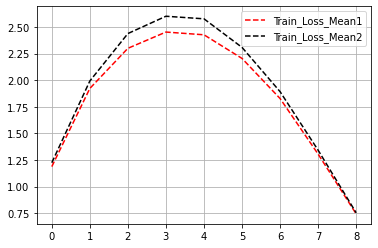

In [26]:
plt.figure(1)
plt.plot(Train_Loss_Mean1,'r--',label='Train_Loss_Mean1')
plt.plot(Train_Loss_Mean2,'k--',label='Train_Loss_Mean2')
plt.legend()
plt.grid()

In [27]:
# for i in range(1,10):
#     for j in range(int(num_test/4)+1):
#         plt.figure()
#         plt.figure(figsize=(12,4))
#         plt.plot(train_pred[j*origin_day*4:(j+1)*origin_day*4,i-1],'k-',label=f'Train_Pred_Quantile{i/10}')
#         plt.plot(Original_trainY[j*origin_day*4:(j+1)*origin_day*4,0],'r--',label=f'trainY')
#         plt.grid()
#         plt.legend()

In [28]:
for q in range(len(tau)):
    exec("Predict_origin%d=np.zeros((TEST.shape[0],origin_day))"%(q+1))
    exec("Predict_origin%d=Make_Data(TEST,Test_Predict_Ensemble%d,seq_length,future_length,Min,den,one_day,tau)"%(q+1,q+1))

In [29]:
test_pred=np.zeros((origin_day*num_test,len(tau)))
for i in range(len(tau)):
    for j in range(num_test):
        exec("test_pred[origin_day*j:(j+1)*origin_day,i]=np.transpose(np.array(Predict_origin%d[j,:]))"%(i+1))

In [30]:
Re_TESTX=np.reshape(TEST,(TEST.shape[0],TEST.shape[1]))
PredX_2days_ago=Re_TESTX[:,seq_length-60:]
PredX_One_2days_ago=one_day_to_original_day(PredX_2days_ago)
PredX_Re_2days_ago=Re_MinMaxScaler(PredX_One_2days_ago,Min,den)

In [31]:
testX_Draw=np.zeros((origin_day*num_test,1))
for j in range(num_test):
    testX_Draw[origin_day*j:(j+1)*origin_day,0]=np.transpose(np.array(PredX_Re_2days_ago[j,:]))

In [32]:
Pred=test_pred
Pred=np.array(Pred)

In [33]:
# k=int(num_test/4)+1
# for i in range(1,10):
#     for j in range(int(num_test/4)+1):
#         plt.figure(k*i+j+1)
#         plt.figure(figsize=(16,4))
#         plt.plot(testX_Draw[j*origin_day*4:(j+1)*origin_day*4,0],'g-',label=f'2_days_ago_Quantile{i/10}')
#         plt.plot(Pred[j*origin_day*4:(j+1)*origin_day*4,i-1],'k-',label=f'Pred_Quantile{i/10}')
#         plt.plot(Best[j*origin_day*4:(j+1)*origin_day*4,i],'r--',label=f'Best_Quantile{i/10}')
#         plt.plot(Pre_Best[j*origin_day*4:(j+1)*origin_day*4,i],'b--',label=f'Pre_Best_Quantile{i/10}')
#         plt.grid()
#         plt.legend()

## 최종 제출

In [34]:
for i in range(9):
    submission[f'q_0.{i+1}'] = test_pred[:,i]
    
print(submission)


                      id  q_0.1  q_0.2  q_0.3  q_0.4  q_0.5  q_0.6  q_0.7  \
0       0.csv_Day7_0h00m    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1       0.csv_Day7_0h30m    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2       0.csv_Day7_1h00m    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3       0.csv_Day7_1h30m    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4       0.csv_Day7_2h00m    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...                  ...    ...    ...    ...    ...    ...    ...    ...   
7771  80.csv_Day8_21h30m    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
7772  80.csv_Day8_22h00m    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
7773  80.csv_Day8_22h30m    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
7774  80.csv_Day8_23h00m    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
7775  80.csv_Day8_23h30m    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

      q_0.8  q_0.9  
0       0.0    0.0  
1       0.0    0.0  
2       0.0 

In [35]:
print('{:0.3f}s'.format(time.time()-start))

1966.237s


In [36]:
np.savetxt(f'{file_name}.csv', submission, header="id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9" ,comments='',delimiter = ',', fmt='%s')